### EXAMPLE 1: Deterministic Kuramoto-Sivashinsky 
In this example we show how one runs the deterministic KS equation. 

In [19]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from jax import config
config.update("jax_enable_x64", True)

 The dictionary is specified in models/ETD_KT_CM_JAX_Vectorised.py, and loaded in as follows:

In [20]:
signal_params = ConfigDict(KS_params)
print(signal_params)

Advection_basis_name: none
E: 1
Forcing_basis_name: none
P: 0
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_ETDRK4
noise_magnitude: 0.0
nt: 600
nx: 256
tmax: 150.0
xmax: 100.53096491487338
xmin: 0.0



Now we specify the model refered to as a signal model, by instantiating the class, and then specify the initial condition. 

In [21]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
print(initial_signal.shape)

(1, 256)


To run the model outputting all timesteps we run the signal model, with nmax timesteps.

In [22]:
key = jax.random.PRNGKey(0)
final, all = signal_model.run(initial_signal, signal_model.params.nt, None, key)


This results in a (nt, E, nx) sized array, nt denotes the number of timesteps, E denotes the number of ensemble members, nx denotes the number of spatial points.

In [23]:
print(all.shape) # particles

(600, 1, 256)


Here we insert the initial condition into the outputted solution. 

In [24]:
print(initial_signal.shape)
print(all.shape)
signal = jnp.concatenate([initial_signal[None,...], all], axis=0)
print(signal.shape)  # (nt+1, n_particles, n_states)

(1, 256)
(600, 1, 256)
(601, 1, 256)


We plot an interactive plot

In [25]:
def plot(time_index):
    plt.figure(figsize=(8, 4), dpi=300)
    plt.plot(signal_model.x, signal[time_index, 0, :], color='k', lw=2)
    plt.xlabel('Spatial coordinate $x$', fontsize=14)
    plt.ylabel('Signal $u(x)$', fontsize=14)
    plt.title(f'Kuramoto-Sivashinsky at $t={time_index * signal_model.params.dt:.2f}$', fontsize=16)
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xlim(signal_model.x[0], signal_model.x[-1])
    plt.tight_layout()
    plt.show()

interact(plot, time_index=(0, signal_model.params.nt))

interactive(children=(IntSlider(value=300, description='time_index', max=600), Output()), _dom_classes=('widge…

<function __main__.plot(time_index)>

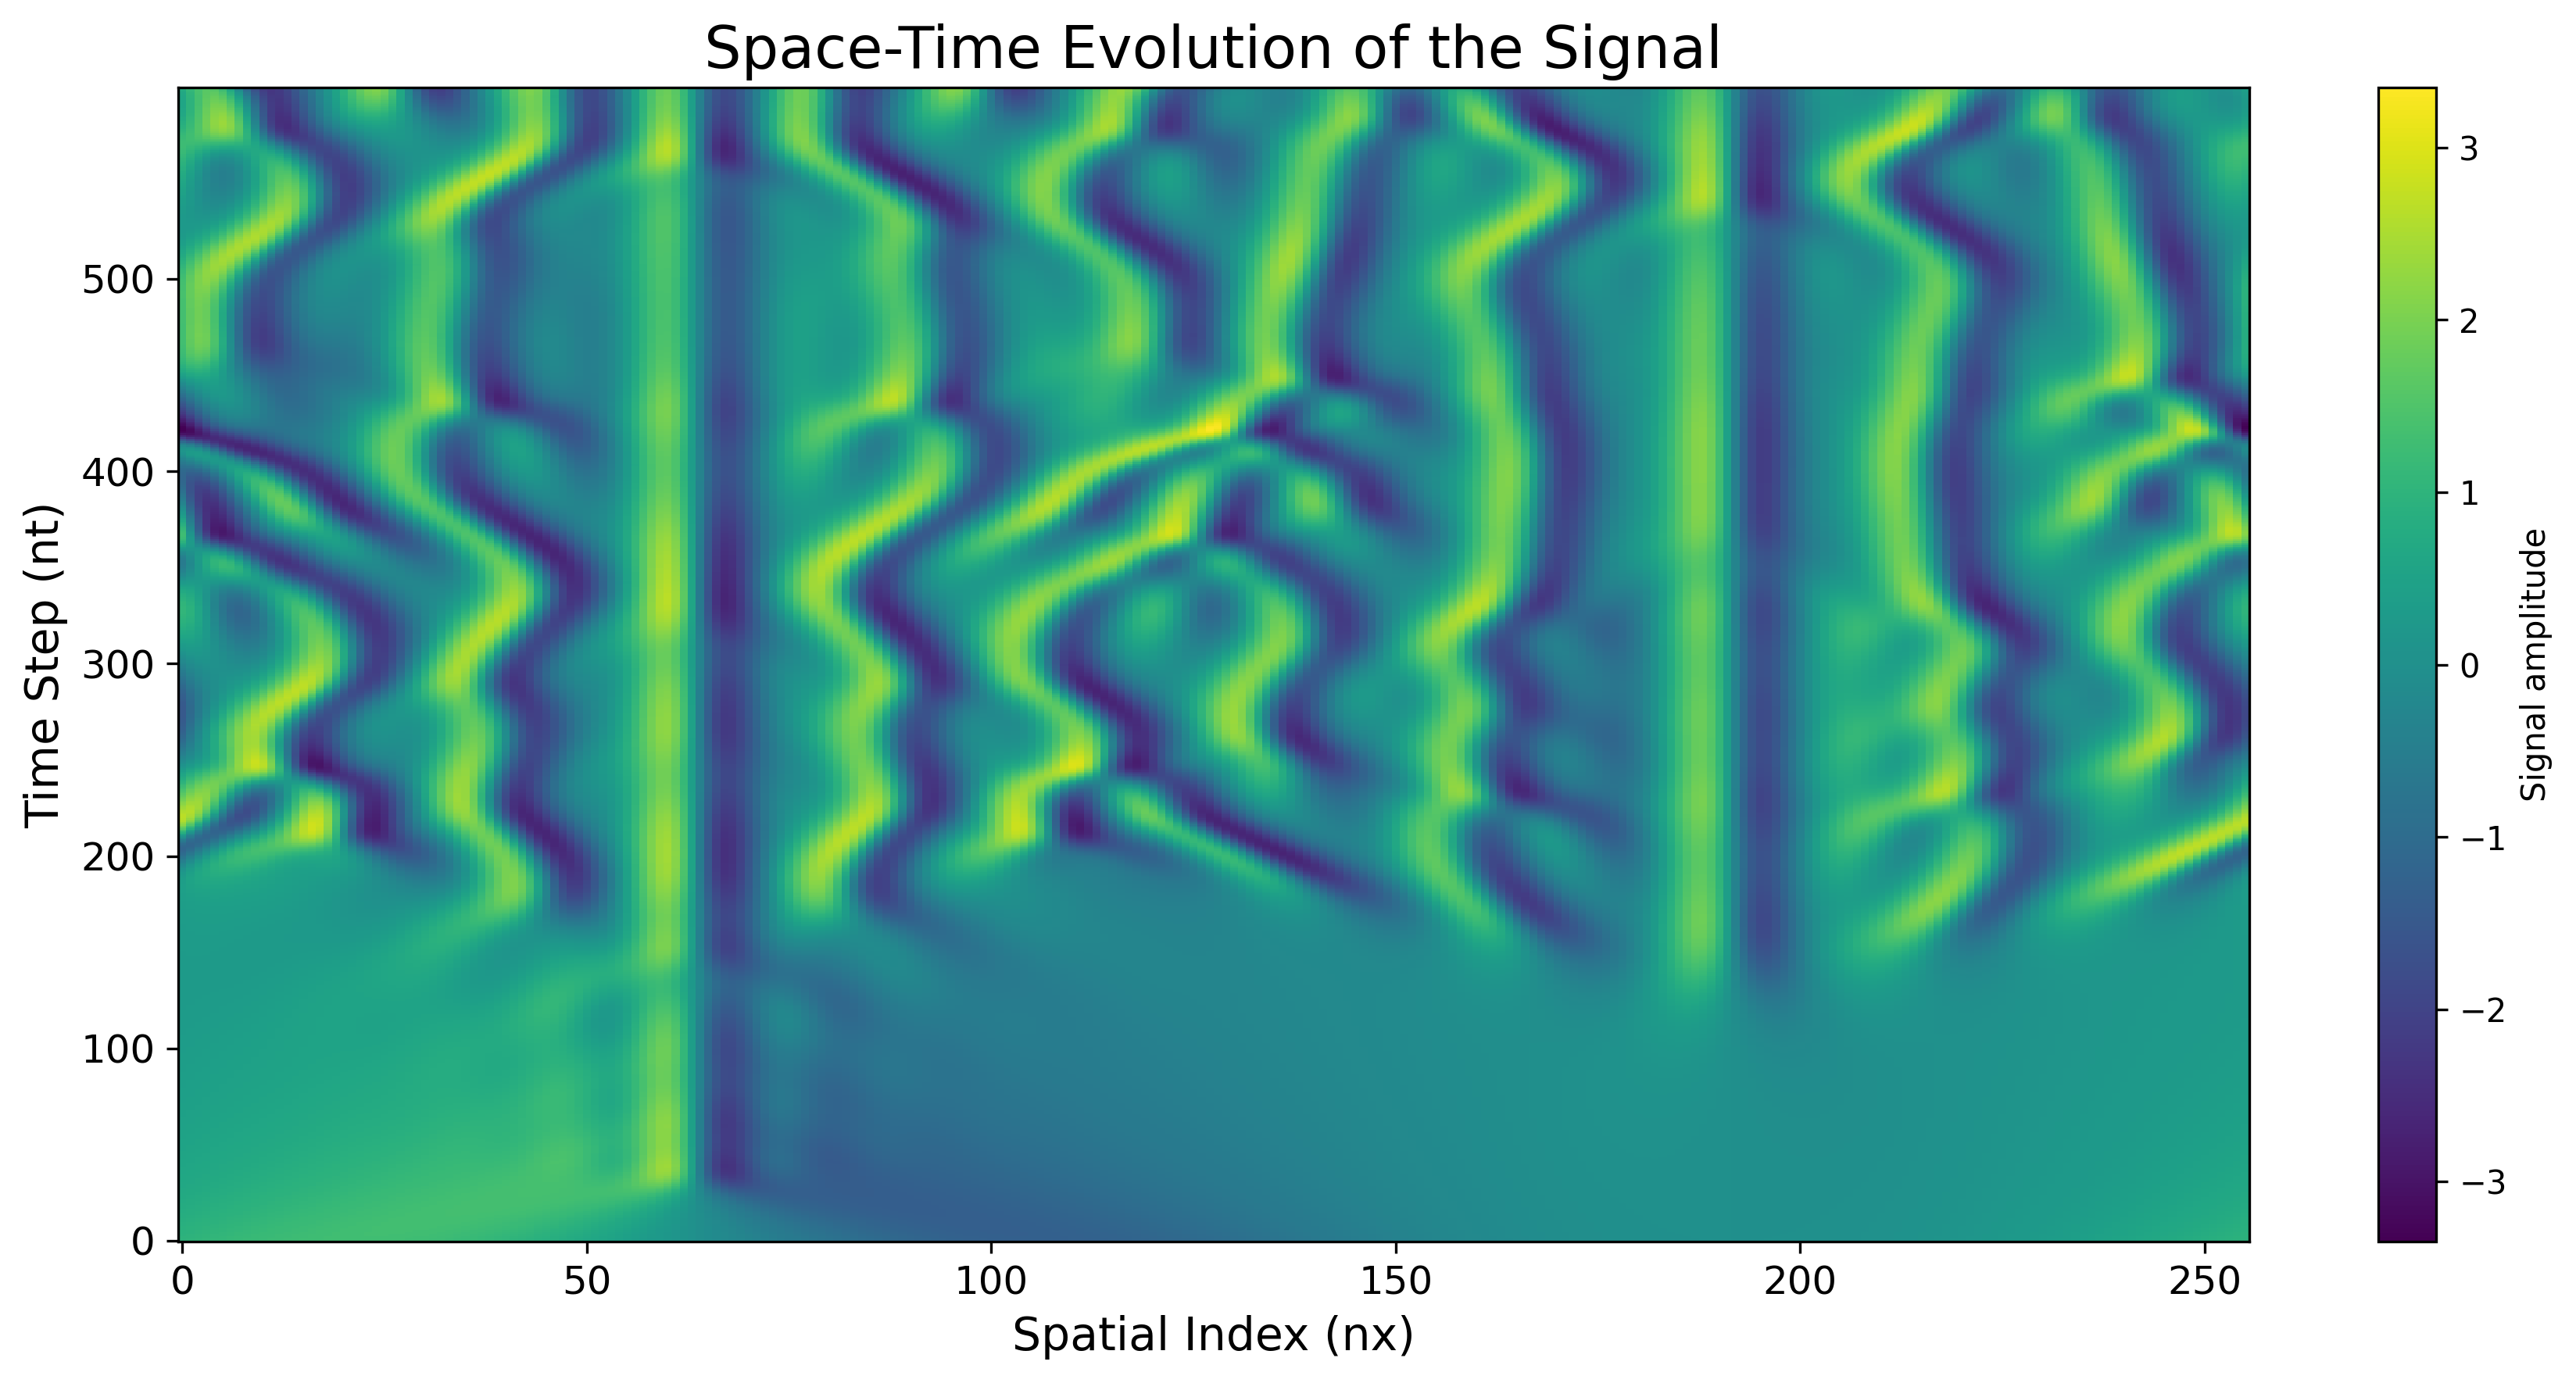

In [26]:
plt.figure(figsize=(12, 6), dpi=300)
im = plt.imshow(
    all[:, 0, :],
    aspect='auto',
    origin='lower',
    cmap='viridis',
    interpolation='none',
    vmin=all[:, 0, :].min(),
    vmax=all[:, 0, :].max()
)
plt.colorbar(im, label='Signal amplitude')
plt.title('Space-Time Evolution of the Signal', fontsize=18)
plt.xlabel('Spatial Index (nx)', fontsize=14)
plt.ylabel('Time Step (nt)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()